# Epidemic mitigation project

For question 3 we reuse the tutorial environment

### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
!pip install gym==0.26.2

ERROR: (Gentoo) Please run pip with the --user option to avoid breaking python-exec


In [54]:
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
import seaborn as sns

SEED = 1337

%matplotlib inline

In [55]:
# Some code to make the picture a bit nicer for the report
SAVE_REPORT = False
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
# does need cm-super, dvipng and latex to be installed
if SAVE_REPORT:
        plt.rcParams.update(tex_fonts)

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim


In [56]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

In [57]:
action_state = torch.Tensor([*map(int,dyn.get_action().values())])
action_state

tensor([0., 0., 0., 0.])

## Implementing the DQN agent, with binary action space

In [58]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



In [59]:
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_VACCINATE = 3
ACTION_HOSPITALIZE = 4

SCALE = 100

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    # Get previous actions
    action = dyn.get_action()
    # Update actions (only one action can be toggled at the same time=
    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
    elif a == ACTION_HOSPITALIZE:
        action['hospital'] = not action['hospital']
    
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # Create action toggle state
    actionState = torch.Tensor([[*map(float,dyn.get_action().values())]])
    obvSpace = torch.Tensor(np.stack((infected, dead))).to(device).unsqueeze(0)
    return obvSpace, actionState

In [60]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"Number cities: {dyn.n_cities} and env_step_length: {dyn.env_step_length}")
print(f"sampled action : {action_space.sample()}")
example_obs = observation_space.sample()
print(f"Sampled observation (shape {example_obs.shape}) first dimension is infected & dead")
#plt.matshow(observation_space.sample()[0,:,:])
#plt.show()

Number cities: 9 and env_step_length: 7
sampled action : 3
Sampled observation (shape (2, 9, 7)) first dimension is infected & dead


In [61]:
env = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor
        )

#### 3.a) implementing Deep Q-Learning

In [62]:
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import seaborn as sns
import pandas as pd
import pickle

random.seed(SEED)

In [63]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [64]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(n_observations, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        obvSpace, actionState = x
        obvSpace = obvSpace**0.25
        obvSpace = self.flatten(obvSpace)
        # Combine observations with current toggle state
        x = torch.cat((obvSpace,actionState),axis=1)
        x = F.relu(self.input(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

In [87]:
# Parameters given by the assignment
# TODO maybe try some hyperparameter tuning after we know the DQN works
LR = 10**-4#10**-5
DF = 0.9
MS = 20_000
BS = 128 #2048

update_every = 5 # episodes
episodes = 1000#500
average_over = 1

In [88]:
# Utility function used later
def flatten(l):
    return [item for sublist in l for item in sublist]

In [89]:
class DQNagent(Agent):
    def __init__(self,  env:Env, eps=0.7):
        self.env = env
        self.n_actions = env.action_space.n
        # The number of observations are the obs from env and the toggle action space
        # -1 since the space doesn't contain toggle nothing
        self.n_observations = spaces.utils.flatdim(env.observation_space) + self.n_actions - 1
        self.dqnQtheta = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat.load_state_dict(self.dqnQtheta.state_dict())
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqnQtheta.parameters(), lr=LR, amsgrad=True)
        self.epsilon = eps

    def load_model(self, savepath):
        loaded_state_dict = torch.load(savepath)    
        self.dqnQtheta.load_state_dict(loaded_state_dict)
        self.dqnQhat.load_state_dict(loaded_state_dict)

    def save_model(self, savepath):
        torch.save(self.dqnQtheta.state_dict(), savepath)
        
    # Following alg. 1 in https://arxiv.org/pdf/1312.5602.pdf
    def optimize_model(self,):
        # Heavily based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        if len(self.memory) < BS:
            return
        transitions = self.memory.sample(BS)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        #print(f"non_final_mask: {non_final_mask.shape}") #torch.Size([BS])
        non_final_next_states = (torch.cat([s[0] for s in batch.next_state
                                                    if s is not None]),
                                torch.cat([s[1] for s in batch.next_state
                                                    if s is not None]))
        
        # Since our state is a tuple of the obs and the toggle states we need to do some zip magic
        state_batch = tuple(map(torch.cat,[*zip(*batch.state)]))
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)

        # Compute  Q_sigma(sj, aj) for all states.
        state_action_values = self.dqnQtheta(state_batch).gather(1, action_batch)

        # Compute rj + DF * max_a' Q_hat(sj+1, a') for all non-final states,
        # for all final states values are 0
        next_state_values = torch.zeros(BS, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.dqnQhat(non_final_next_states).max(1)[0]
        next_state_values = next_state_values.unsqueeze(1)
        expected_state_action_values = reward_batch + (DF * next_state_values)

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model, where we update Q_0 & Q_hat at the same time
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.dqnQtheta.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        #torch.manual_seed(SEED)
        # torch.use_deterministic_algorithms(True) # TODO, need to fix that this works
        pass
    
    def act(self, obs):
        # eps greedy choosing
        if random.random() < 1 - self.epsilon:
            # Exploitation
            with torch.no_grad():
                # The unmitigated agent always takes the same action, i.e. do nothing
                containment = self.dqnQtheta(obs) # flatten not necessary bc of nn.Flatten
                # max(1) returns lagest column vector per row, [1] of that the index of it 
                #print(containment,containment.max(1)[1].view(1, 1))
                return containment.max(1)[1].view(1, 1)
        else:
            # Exploration
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

In [90]:
# Runs the agent over one episode
def run_episode(agent, env, seed, soft_update=False):
    finished = False
    obs, _ = env.reset(seed)
    torch.manual_seed(seed)
    rewards = []
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        # Meaning also the log info is per week
        new_obs, R, finished, _ = env.step(action)
        # Log this step
        #deaths.append(info.total.dead)
        rewards.append(R)
        #log.append(info) # save the information dict for logging
        # If terminal => no next state exits
        next_obs = None if finished else new_obs
        # Save to replay buffer
        agent.memory.push(obs, action, next_obs, R)
        # Move to the next state
        obs = next_obs
        # Optimize the model
        agent.optimize_model()
            
    return np.sum([r.numpy()[0] for r in rewards])

In [91]:
best_eval_reward = -np.inf

def evaluate_agent(agent, env, seed, eval_episodes=20, save_best=True):
    last_eps = agent.epsilon
    agent.dqnQtheta.eval()
    agent.epsilon = 0
    eval_rewards = []
    for i in range(eval_episodes):
        eval_rewards.append(run_episode(agent, env, seed*i))
    mean_eval_reward = np.mean(eval_rewards)
    agent.epsilon = last_eps
    agent.dqnQtheta.train()
    # check if this is the best reward and if so save the model
    global best_eval_reward
    if save_best and mean_eval_reward > best_eval_reward:
        best_eval_reward = mean_eval_reward
        agent.save_model(savepath="Q4.1b_best_model.mdl")
        print(f"Best model updated with mean eval reward: {mean_eval_reward:.2f}")
    return mean_eval_reward

In [92]:
def run_simulation(agent,env,seed, eps_0=0.7, eps_min=0.2):
    """ Run the simulation """
    training_trace = []
    eval_trace = []
    for i in range(episodes):
        print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%)", end="\r")
        agent.epsilon = max(eps_0*(episodes-i)/episodes, eps_min)
        reward = run_episode(agent, env, seed=seed+i)
        training_trace.append(reward)
        if i % update_every == 0:
            # Update the target network fully, copying all weights and biases
            agent.dqnQhat.load_state_dict(agent.dqnQtheta.state_dict())
        if (i % 50 == 0 or i == episodes-1) and i != 0:
            # run eval 20 episodes average with epsilon of 0
            mean_eval_reward = evaluate_agent(agent, env, seed+i, eval_episodes=20)
            print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%) - eval reward: {mean_eval_reward:.2f}")
            eval_trace.append(mean_eval_reward)
    
    return training_trace, eval_trace

# Eval trace averaged over n runs, training_trace can be used together
training_trace, eval_trace = list(zip(*[run_simulation(DQNagent(env),env,SEED) for _ in range(average_over)]))
training_trace = flatten(training_trace)
eval_trace = np.mean(eval_trace, axis=0)

Best model updated with mean eval reward: -100.61
Episode  51/1000 (5.00%) - eval reward: -100.61
Best model updated with mean eval reward: -86.00
Episode 101/1000 (10.00%) - eval reward: -86.00
Best model updated with mean eval reward: -84.92
Episode 151/1000 (15.00%) - eval reward: -84.92
Best model updated with mean eval reward: -79.18
Episode 201/1000 (20.00%) - eval reward: -79.18
Best model updated with mean eval reward: -65.90
Episode 251/1000 (25.00%) - eval reward: -65.90
Episode 301/1000 (30.00%) - eval reward: -75.91
Best model updated with mean eval reward: -36.95
Episode 351/1000 (35.00%) - eval reward: -36.95
Best model updated with mean eval reward: 17.86
Episode 401/1000 (40.00%) - eval reward: 17.86
Episode 451/1000 (45.00%) - eval reward: 1.21
Episode 501/1000 (50.00%) - eval reward: 7.29
Episode 551/1000 (55.00%) - eval reward: 16.08
Episode 601/1000 (60.00%) - eval reward: 17.40
Episode 651/1000 (65.00%) - eval reward: 2.39
Best model updated with mean eval reward: 

In [93]:
def save_trace(name, combined):
    with open(name, 'wb') as f:
        pickle.dump(combined, f)

def load_trace(name='Q4.1b-trace.pickle'):
    with open(name, 'rb') as f:
        combined = pickle.load(f)
        return combined

In [94]:
combined_a = pd.concat([
    pd.DataFrame({
        "Episode": flatten([[i]*average_over for i in range(int(len(training_trace)/average_over))]),
        "Reward": training_trace,
        "Trace": ["Training" for _ in range(len(training_trace))],
        "Exploration": ["Fixed" for _ in range(len(training_trace))]
    }),
    pd.DataFrame({
        "Episode": [50 * i for i in range(len(eval_trace))],
        "Reward": eval_trace,
        "Trace": ["Evaluation" for _ in range(len(eval_trace))],
        "Exploration": ["Fixed" for _ in range(len(eval_trace))]
    })
])
save_trace('Q4.1b-trace.pickle', combined_a)

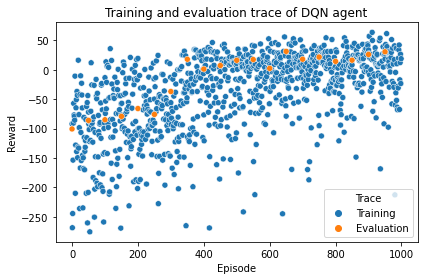

In [95]:
combined_a = load_trace(name='Q4.1b-trace.pickle')
sns.scatterplot(data=combined_a, x="Episode", y="Reward", hue="Trace")
plt.title("Training and evaluation trace of DQN agent")
plt.tight_layout()
plt.show()

TODO: Does your agent learn a meaningful policy?
It does not seem that this agent learns a meaningful policy, because the reward does not seem to increase by much over the training time.
This might not be completely the fault of this agent though, because this agent is not allowed to touch any other action than confinment.

Record three example episodes with best policy and plot one of them.

In [96]:
agent = DQNagent(env)
agent.load_model("Q4.1b_best_model.mdl")

def run_episode_simulation(agent,env,seed):
    """ Run the simulation """
    agent.dqnQtheta.eval()
    agent.epsilon = 0
    finished = False
    obs, _ = env.reset(seed)
    torch.manual_seed(seed)
    rewards = []
    deaths = []
    log = []
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        # Meaning also the log info is per week
        obs, R, finished, info = env.step(action)
        # Log this step
        deaths.append(info.total.dead)
        rewards.append(R)
        log.append(info) # save the information dict for logging
    """ Parse the logs """
    deaths = np.array(deaths)
    rewards = np.array([r.squeeze() for r in rewards])
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return deaths, rewards, total, cities, actions

three_example_episodes = [run_episode_simulation(agent,env,SEED+i) for i in range(3)]

In [101]:
# Choose one of the example episodes and plot the results
deaths, rewards, total, cities, actions = three_example_episodes[2]

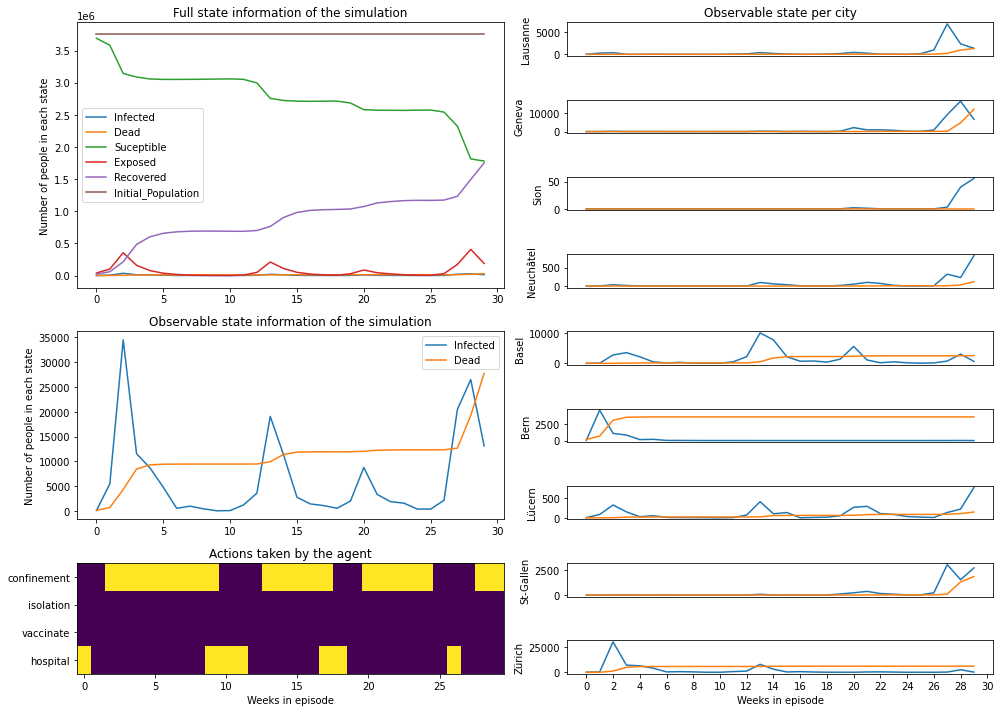

In [102]:
# Single plot
size = set_size(700) if SAVE_REPORT else (14, 10)
fig = plt.figure(figsize=size)
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend([t.title() for t in total.keys()])
ax_leftstate.set_title('Full state information of the simulation')
ax_leftstate.set_ylabel('Number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['Infected','Dead'])
ax_leftobs.set_title('Observable state information of the simulation')
ax_leftobs.set_ylabel('Number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions taken by the agent')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Weeks in episode')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('Weeks in episode')
ax_right['Zürich'].xaxis.set_major_locator(ticker.MultipleLocator(2.000))
ax_right['Lausanne'].set_title('Observable state per city')

fig.tight_layout()
fig.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q4.1b-a-complete.png', dpi=300)
else:
    plt.show()

TODO: Interpret this policy.

From looking at a few full episodes using this policy, it seems that this agent will just always confine all people as this is on average the best thing that can be done by this agent.
Given how the reward is calculated, expecially looking at the amount of deaths, we see that such a simple policy does improve the spread and on average keeps most cities completely save.

#### 3b) decreasing exploration

In [103]:
agent = DQNagent(env)
agent.load_model("Q4.1b_best_model.mdl")
def simulation(agent,env,n):
    info = []
    for i in range(n):
        # Run the agent with seed i, returns deaths, rewards, total, cities, actions
        info.append(run_episode_simulation(agent,env,SEED+i))
    return info
info = simulation(agent,env,50)

In [104]:
# process simulations
conf_days = [np.sum(c[4]["confinement"])*7 for c in info]
rewards = [np.array(np.sum(c[1])) for c in info] # TODO should we plot the average mean per step or the average total reward?
deaths = [d[0][-1] for d in info] 

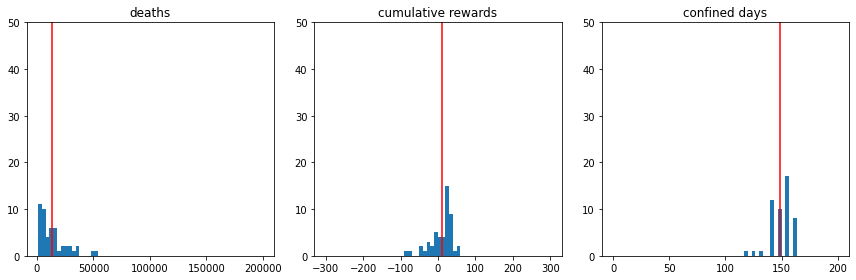

Average death number: 13533.46
Average cumulative reward: 9.882808685302734
Average number of confined days: 148.68


In [105]:
""" As it is deterministic we really don't need to get anything else than deaths and rewards """
""" Plot example """
fig, ax = plt.subplots(1,3,figsize=(12,4))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')

TODO: Did the reinforcement learning policy outperform Pr. Russo's policy?